In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# from bokeh.io import output_notebook, show
# from bokeh.plotting import figure, output_file
# from bokeh.models import ColumnDataSource, Range1d
# from bokeh.layouts import gridplot
# from bokeh.models import LinearColorMapper, ColorBar
# from bokeh.transform import transform
# output_notebook()

plotpar = {'axes.labelsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'legend.fontsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
df = pd.read_csv("../data/bokeh_df.csv")

In [3]:
gmag = 11.1740
bp = 11.925369
rp = 10.37407
teff = 4425
parallax = 15.4175
prot = 17

In [4]:
def abs_mag(m, D):
    return m - 5*np.log10(D) + 5

abs_G = abs_mag(gmag, 1./parallax*1e3)

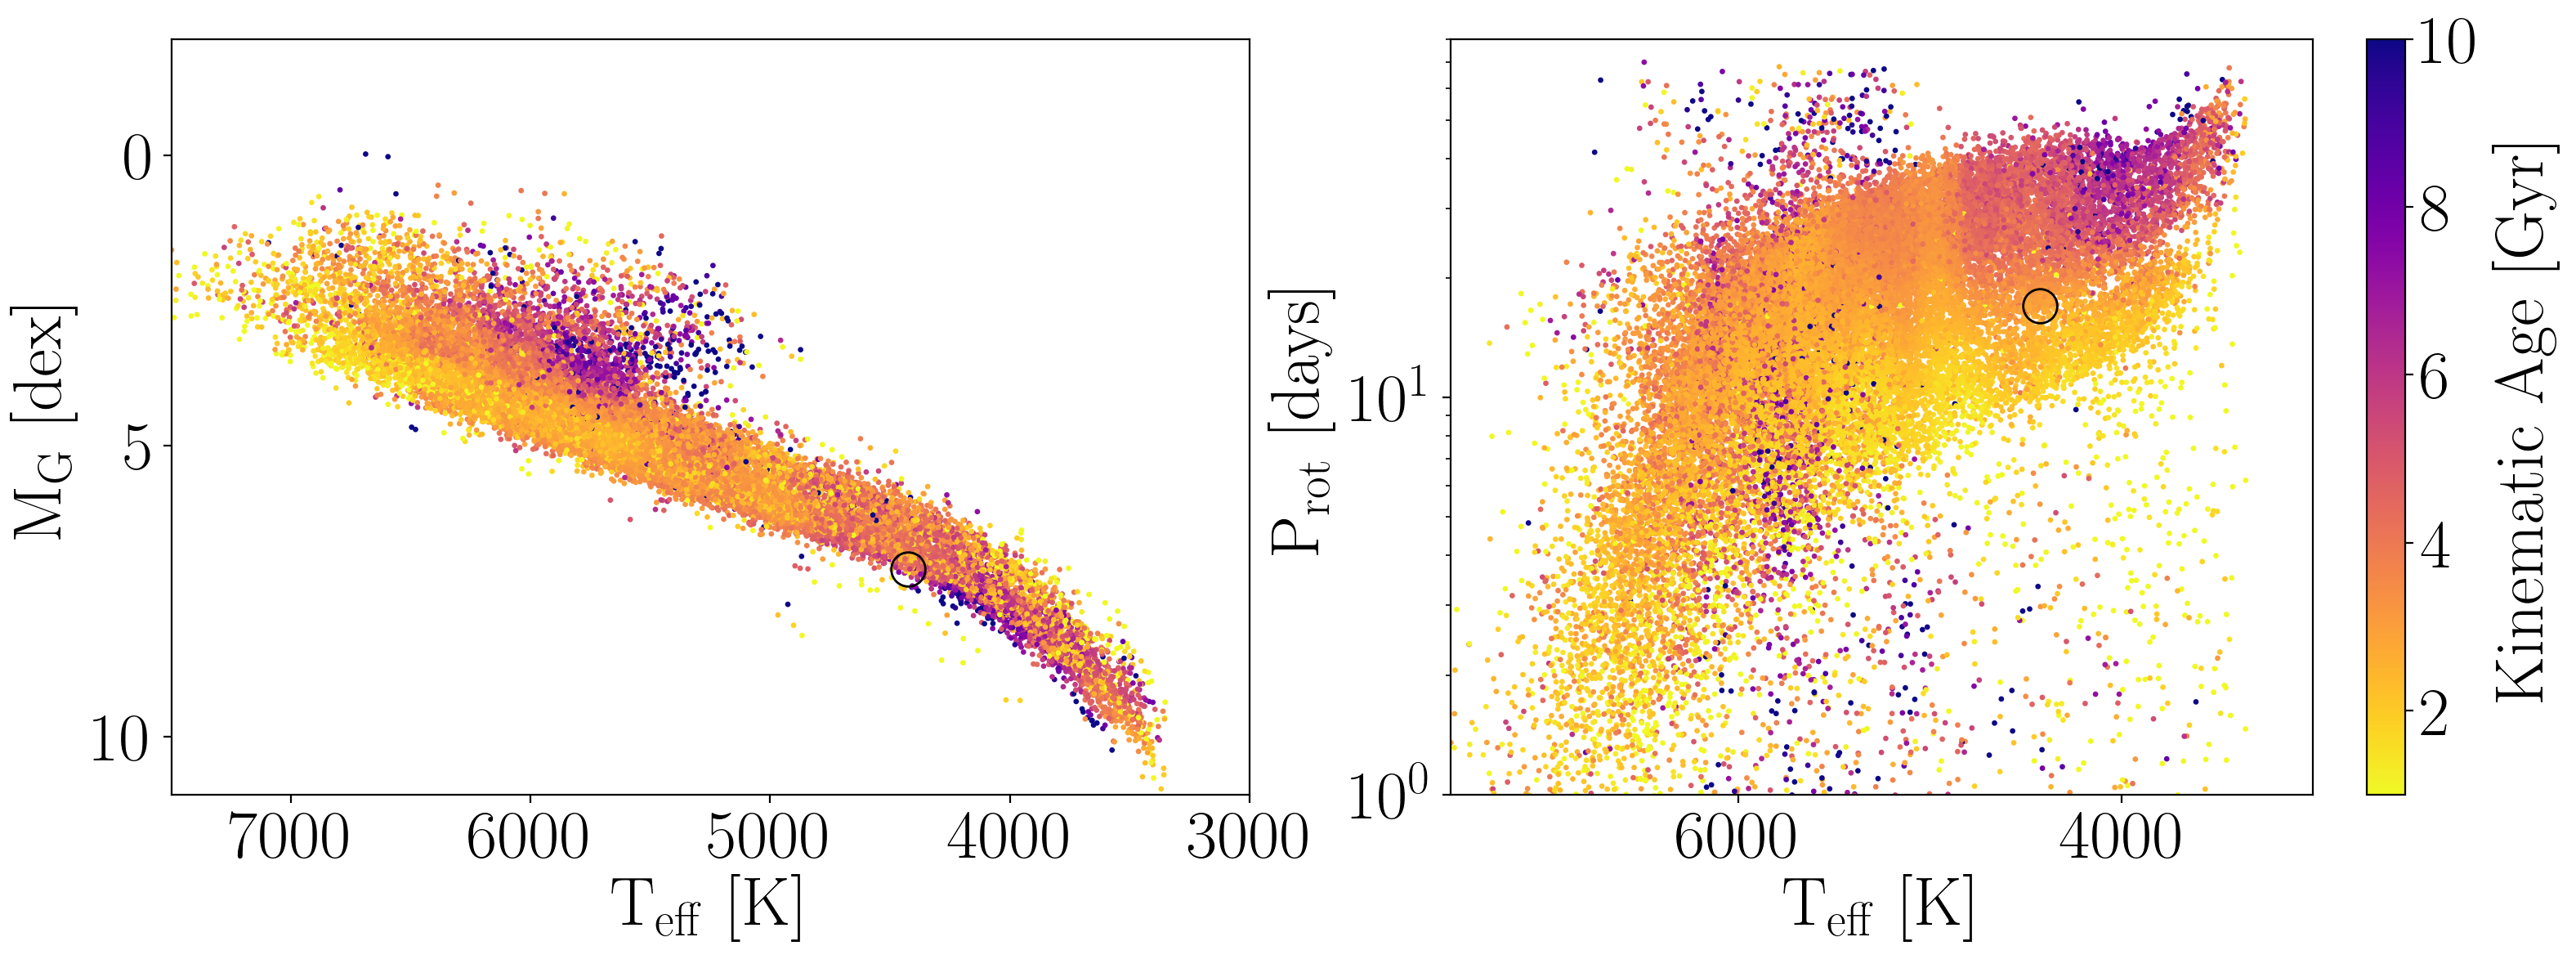

In [5]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.scatter(df.teff, df.M_G, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.plot(teff, abs_G, "o", color="none", mec="k", ms=15, zorder=1)

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.teff, df.prot, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")
ax2.plot(teff, prot, "o", color="none", mec="k", ms=15, zorder=1)

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

In [6]:
import stardate2 as sd2

gp = sd2.GP_model()
print(gp.pred_at(np.log10(3.5e9), teff))

[17.18188353]


In [35]:
test_ages = np.linspace(9, 10, 9)
test_teffs = np.linspace(3000, 7000, 100)
print(1e-9*(10**test_ages))

[ 1.          1.33352143  1.77827941  2.37137371  3.16227766  4.21696503
  5.62341325  7.49894209 10.        ]


In [8]:
prots = np.zeros((len(test_ages), len(test_teffs)))
for i, a in enumerate(test_ages):
    for j, t in enumerate(test_teffs):
        prots[i, j] = gp.pred_at(a, t)

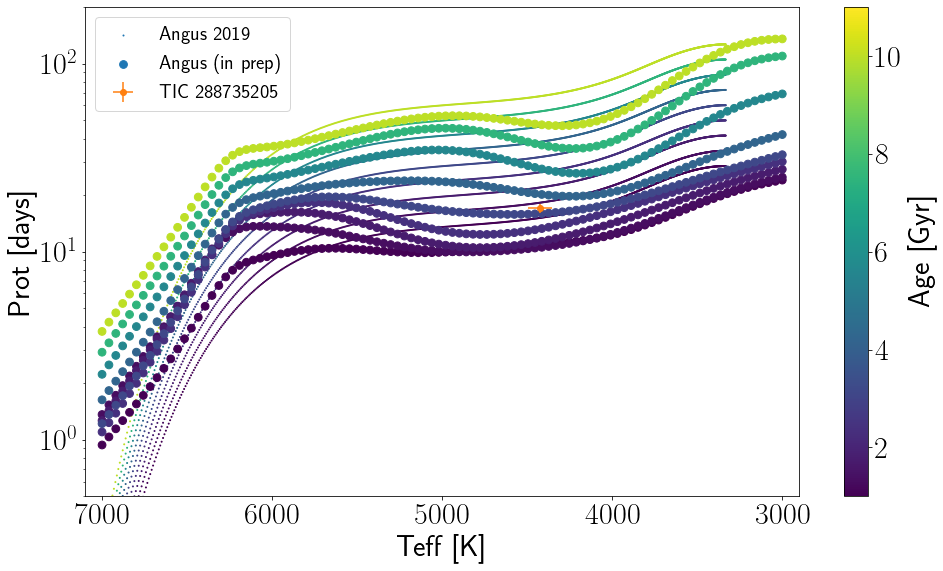

In [33]:
import kinematics_and_rotation as kr

plt.figure(figsize=(16, 9))

# logages = np.log10(np.arange(1, 10)*1e9)
bprps = np.linspace(.4, 2.7, 1000)
teffs = kr.bprp_to_teff(bprps)
for i, a in enumerate(test_ages[:-1]):
    _age = (10**test_ages[i])*1e-9
    plt.scatter(teffs, sd2.angus_2019_model(a, bprps), c=np.ones(len(teffs))*_age, s=1,
                vmin=1, vmax=11, zorder=0)
_age = (10**test_ages[-1])*1e-9
plt.scatter(teffs, sd2.angus_2019_model(test_ages[-1], bprps), c=np.ones(len(teffs))*_age, s=1,
            vmin=1, vmax=11, zorder=0, label="Angus 2019")

for i, p in enumerate(prots[:-1]):
    _age = (10**test_ages[i])*1e-9
    plt.scatter(test_teffs, p, c=np.ones(len(p))*_age, vmin=1, vmax=11, s=60,
               zorder=1)
_age = (10**test_ages[-1])*1e-9
plt.scatter(test_teffs, prots[-1], c=np.ones(len(p))*_age, vmin=1, vmax=11, s=60,
            zorder=1, label="Angus (in prep)")

plt.colorbar(label=("Age [Gyr]"))
plt.errorbar(teff, prot, fmt="C1o", yerr=1, xerr=70, label="TIC 288735205")

plt.gca().invert_xaxis()
plt.yscale("log")
plt.xlabel("Teff [K]")
plt.ylabel("Prot [days]")
plt.ylim(.5, 200)
plt.xlim(7100, 2900)
plt.legend()

In [14]:
print(sd2.lnprob(np.log10(1e9), prot, 1, bp-rp, sd2.angus_2019_model))

-0.24242439043066935


In [15]:
import emcee

ndim, nwalkers = 1, 25
p0 = np.random.randn(nwalkers, ndim)*1e-2 + 9

bprp = bp - rp

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[17, 1, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 100);
sampler.reset()
sampler.run_mcmc(state, 1000);

1.0628546811234907


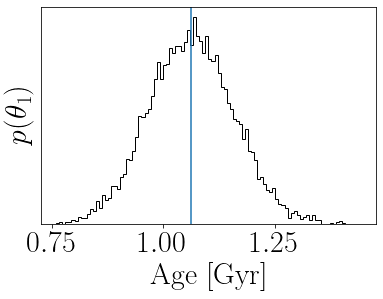

In [16]:
samples = sampler.get_chain(flat=True)
median_age = np.median((10**samples)*1e-9)
print(median_age)

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [23]:
gp = sd2.GP_model()

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[17, 1, teff, gp.pred_at])
p0 = np.random.randn(nwalkers, ndim)*1e-2 + np.log10(3.5e9)
state = sampler.run_mcmc(p0, 500);
sampler.reset()
sampler.run_mcmc(state, 1000);

3.4131748021420885 + 0.26050381115678967 - 0.28529101138685586


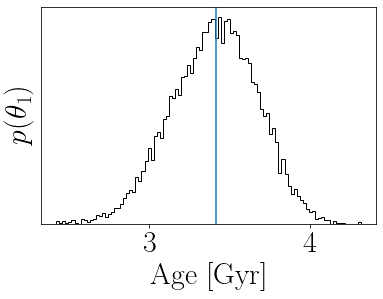

In [31]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(median_age, "+", errp, "-", errm)

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [27]:
import astropy.stats as aps

def make_mask(targets, all_stars, ranges):
    """
    Generic function for binning stars in N-D.
    
    Args:
        targets (array): The properties of the target star (e.g. [teff, prot, mag])
        all_stars (list):  list of arrays of properties for each star.
        ranges (list): The bin sizes.
    """
    ndim = len(targets)
    bounds = []
    m = np.ones(len(all_stars[0]), dtype=bool)
    for i in range(ndim):
        upper_bound = targets[i] + ranges[i]/2.
        lower_bound = targets[i] - ranges[i]/2.
        m &= (lower_bound < all_stars[i]) & (all_stars[i] < upper_bound)
    return m


def calc_dispersion_target(target_teff, target_prot, target_mag, teffs, prots, mags, vels, teffrange, protrange, magrange):
    """
    This function is for calculating dispersions of target stars,  binning in teff, prot and mag.
    
    Args:
        target_teff (float): The Teff of the target star.
        target_prot (float): The prot of the target star.
        target_mag (float): The mag of the target star.
        teffs (array): The Teff array.
        prots (array): The Prot array.
        mags (array): The M_G array.
        vs (array): The velocity array.
        teffrange (float): The teff bin-size
        protrange (float): The Prot bin-size
        magrange (float): The M_G bin-size
        
    Returns:
        dispersions (array): The velocity dispersion for each star.
        
    """
    dispersions = np.zeros(len(target_teff))
    for i in trange(len(target_teff)):
        mask = make_mask([target_teff[i], target_prot[i], target_mag[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        mask2 = np.isfinite(vels[mask])
        if len(vels[mask][mask2]) > 0:
            dispersions[i] = 1.5*aps.median_absolute_deviation(vels[mask][mask2], ignore_nan=True)
    return dispersions

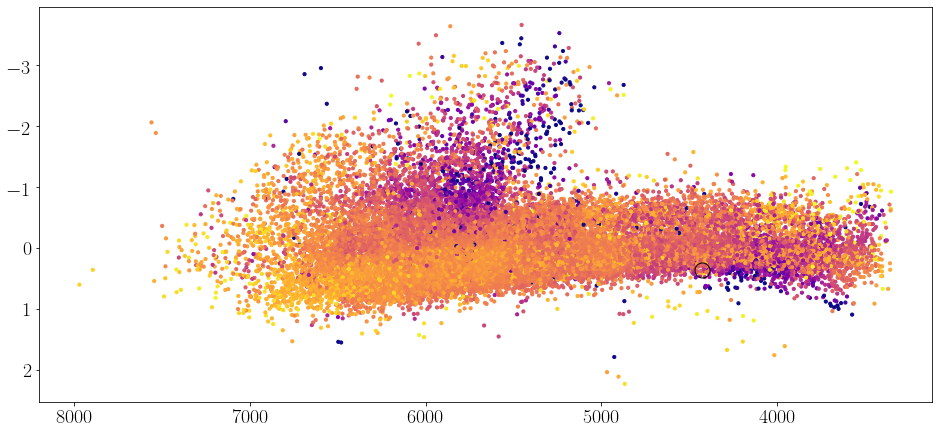

In [34]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(211)

mc = df.teff.values < 8000
p = np.polyfit(df.teff.values[mc], df.M_G.values[mc], 5)

# ax1.scatter(df.color_teffs, df.abs_G, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
ax1.scatter(df.teff, df.M_G-np.polyval(p, df.teff), c=df.kin_age, s=10, vmin=0, vmax=10, cmap="plasma_r")

xs = np.linspace(8000, 3000, 100)
# plt.plot(xs, np.polyval(p, xs))
ax1.invert_yaxis()
ax1.invert_xaxis()


G = df.M_G.values - np.polyval(p, df.teff)
aG = abs_G - np.polyval(p, teff)
ax1.plot(teff, aG, "o", mec="k", color="none", ms=15)

In [28]:
from tqdm import trange

disp = calc_dispersion_target([teff], [np.log10(prot)], [aG], df.teff, np.log10(df.prot.values), G, df.vz.values, 200, .4, .5)

100%|██████████| 1/1 [00:00<00:00, 324.44it/s]


In [29]:
import aviary as av

p_mp, p_mr, p_a = av.get_avr_coefficients()
kin_age = av.v_to_age(disp, p_mr)

In [30]:
kin_age

array([2.80377629])